In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

In [23]:
input_data = np.expand_dims(np.arange(-2.0, 2.0, 0.01), 1)

# Generate output using the sinc function
output_data = np.sinc(5 * input_data)

print(input_data.shape)
print(output_data.shape)

(400, 1)
(400, 1)


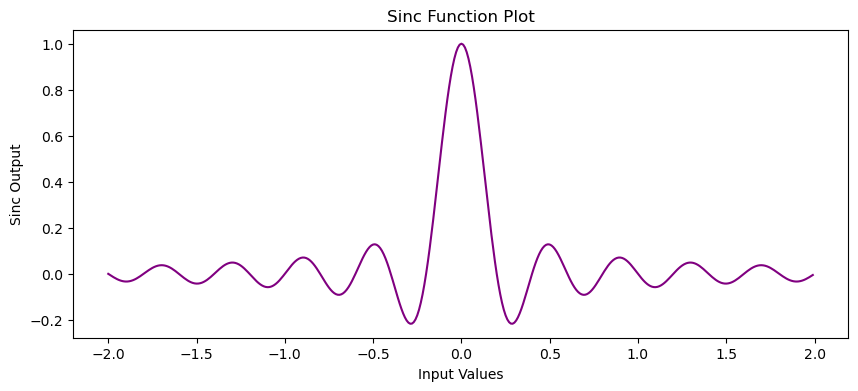

In [24]:
X = torch.tensor(input_data, dtype=torch.float32)
Y = torch.tensor(output_data, dtype=torch.float32)

plt.figure(figsize=(10, 4))
plt.plot(X, Y, color="purple")
plt.title('Sinc Function Plot')
plt.xlabel('Input Values')
plt.ylabel('Sinc Output')
plt.show()

In [25]:
class SincModel(nn.Module):
    def __init__(self):
        super(SincModel, self).__init__()
        self.fc1 = nn.Linear(1, 5)
        self.fc2 = nn.Linear(5, 6)
        self.fc3 = nn.Linear(6, 14)
        self.fc4 = nn.Linear(14, 7)
        self.fc5 = nn.Linear(7, 8)
        self.fc6 = nn.Linear(8, 4)
        self.fc_output = nn.Linear(4, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc_output(x)
        return x

In [26]:
# Instantiate the model and display total parameters
model = SincModel()
num_params = sum(p.numel() for p in model.parameters())
print('Total parameters:', num_params)

Total parameters: 354


In [27]:
def train_model(model, x, y):
    epoch_size = 4000
    loss_arr, epoch_arr, grad_arr = [], [], []
    converged, min_grad, loss_val = False, 0, 0
    print('Starting training process...')

    for epoch in range(epoch_size):
        if converged:
            return epoch_arr, loss_arr, y_prediction, grad_arr

        y_prediction = model(x)
        loss = loss_func(y_prediction, y)
        # Let's clear previous gradients
        optimizer.zero_grad()  
        loss.backward()
        optimizer.step()

        # Storing loss and epoch data
        loss_arr.append(loss.detach().numpy())
        epoch_arr.append(epoch)

        # Compute gradient norm
        grad_all = sum((p.grad.cpu().data.numpy()**2).sum() for p in model.parameters() if p.grad is not None)
        grad_norm = grad_all ** 0.5
        grad_arr.append(grad_norm)

        # Check for convergence
        if grad_norm < 0.001 or epoch == epoch_size - 1:
            print('Convergence criteria met at epoch:', epoch)
            predicted_y = model(x)
            final_loss = loss_func(predicted_y, y)
            total_params = sum(p.numel() for p in model.parameters())

            # Compute Hessian matrix
            H = torch.zeros((total_params, total_params))
            Jacob = torch.autograd.grad(final_loss, list(model.parameters()), create_graph=True)
            Jacob = torch.cat([param.flatten() for param in Jacob])

            for i in range(total_params):
                grad_res = torch.autograd.grad(Jacob[i], list(model.parameters()), retain_graph=True)
                H[i] = torch.cat([g.flatten() for g in grad_res])

            # Eigenvalue computation and minimal ratio calculation
            H_eig = torch.symeig(H).eigenvalues
            positive_eigvals = sum(1 for val in H_eig.tolist() if val > 0)
            minimal_ratio = positive_eigvals / H.shape[0]

            # Output the final loss and minimal ratio
            loss_val = final_loss.data.detach().numpy()
            print(f'Minimal Ratio: {minimal_ratio}, Final Loss: {loss_val}, Epoch: {epoch}')
            break

    print('Training process is completed.')
    return loss_val, minimal_ratio

In [28]:
# Run the training process for multiple models
loss_results = []
minimal_ratios = []

for idx in range(100):
    print(f"Training Model {idx + 1}")
    model = SincModel()
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    final_loss, ratio = model_training(model, X, Y)
    loss_results.append(final_loss)
    minimal_ratios.append(ratio)


Training Model 1
Converged. Final Gradient Norm: 0.000809840257076071
Minimal Ratio: 0.9124293785310734  Loss: 0.047082596  Epoch: 70
Training Complete
Training Model 2
Converged. Final Gradient Norm: 0.0008989914661924942
Minimal Ratio: 0.9152542372881356  Loss: 0.047051925  Epoch: 114
Training Complete
Training Model 3
Converged. Final Gradient Norm: 0.000989635393270158
Minimal Ratio: 0.903954802259887  Loss: 0.0042470475  Epoch: 525
Training Complete
Training Model 4
Converged. Final Gradient Norm: 0.000987142268213438
Minimal Ratio: 0.8050847457627118  Loss: 0.0019947642  Epoch: 909
Training Complete
Training Model 5
Converged. Final Gradient Norm: 0.000973688184063408
Minimal Ratio: 0.8389830508474576  Loss: 0.0019167915  Epoch: 622
Training Complete
Training Model 6
Converged. Final Gradient Norm: 0.0009208836719568856
Minimal Ratio: 0.8361581920903954  Loss: 0.0016039555  Epoch: 1999
Training Complete
Training Model 7
Converged. Final Gradient Norm: 0.0007203739986299435
Minima

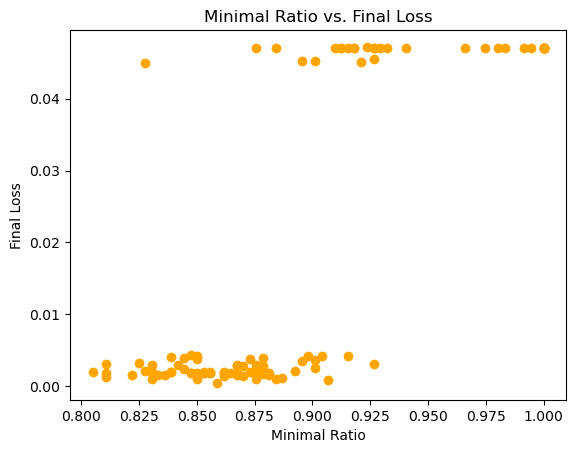

In [29]:
plt.scatter(minimal_ratios, loss_results, color="orange")
plt.xlabel("Minimal Ratio")
plt.ylabel("Final Loss")
plt.title("Minimal Ratio vs. Final Loss")
plt.show()

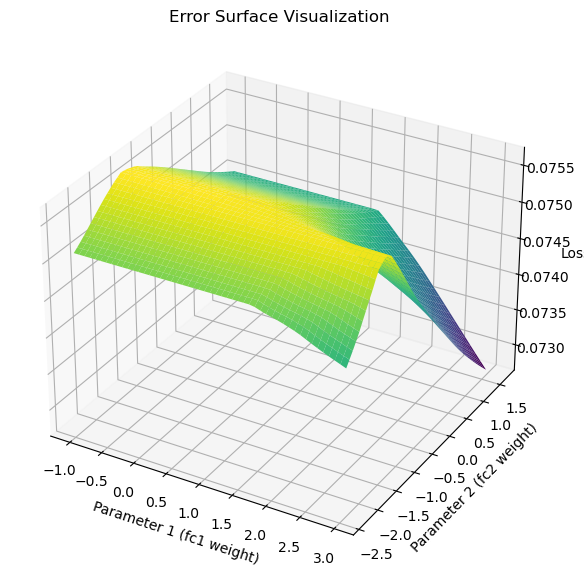

In [30]:
# Instantiate the model
model = SincModel()

# Loss function
loss_fn = torch.nn.MSELoss()

# Visualizing the error surface based on two chosen parameters
def visualize_error_surface(model, X, Y):
    # Get the weights for the two parameters we want to vary
    param_1 = model.fc1.weight[0, 0].detach().item()  # First parameter from fc1 layer
    param_2 = model.fc2.weight[0, 0].detach().item()  # First parameter from fc2 layer
    
    param_1_range = np.linspace(param_1 - 2, param_1 + 2, 50)
    param_2_range = np.linspace(param_2 - 2, param_2 + 2, 50)
    
    loss_surface = np.zeros((len(param_1_range), len(param_2_range)))
    
    # Iterate over the grid of parameter values
    for i, p1 in enumerate(param_1_range):
        for j, p2 in enumerate(param_2_range):
            # SLet'set new parameter values for the two selected parameters
            model.fc1.weight.data[0, 0] = torch.tensor(p1)
            model.fc2.weight.data[0, 0] = torch.tensor(p2)
            
            # Let's calculate the predicted values
            predicted_Y = model(X)
            
            # Let's calculate the loss
            loss = loss_fn(predicted_Y, Y)
            loss_surface[i, j] = loss.item()
    
    # Let's create a meshgrid for the parameter ranges
    param_1_grid, param_2_grid = np.meshgrid(param_1_range, param_2_range)
    
    # Let's plot the error surface
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(param_1_grid, param_2_grid, loss_surface, cmap='viridis')
    
    ax.set_xlabel('Parameter 1 (fc1 weight)')
    ax.set_ylabel('Parameter 2 (fc2 weight)')
    ax.set_zlabel('Loss')
    ax.set_title('Error Surface Visualization')
    
    plt.show()

# Call the visualize error surface function to visualize the error surface
visualize_error_surface(model, X, Y)